In [1]:
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.dirname('../.'))
from ml.SampleClass import Sample
from ml.ControllerClass import Controller
from scripts.utils import get_path
from scripts.load_and_save import save_vol_as_nii

from ml.models.HessNet import HessBlock, HessNet, HessNet2, GaussianBlur3D, HessianTorch
from ml.models.unet3d import U_Net, U_HessNet, ParallelNet
from ml.models.unet2d import U_Net2d

**<h1>MIP**

In [69]:
#model_name = 'Unet2d_16ch'
#model_name = 'Unet3d_16ch'
model_name = 'HessNet'

sample_name = 'IXI111'

In [70]:
path_to_GT = f'/home/msst/Documents/medtech/data/Inference_IXI/{sample_name}'
path_to_SEG = get_path(f'/home/msst/IXI_MRA_work/{sample_name}', model_name)
#GT
sample = Sample(path_to_GT)
subject = sample.get_subject()
vessels_GT = subject.vessels.data[0].numpy()
brain = subject.brain.data[0].numpy()
vessels_GT_masked = vessels_GT*brain

#SEG
img = tio.LabelMap(path_to_SEG)
vessels_SEG = img.data[0].numpy()
vessels_SEG_masked = vessels_SEG*brain

In [71]:
CROP_COEF = 0.08
def transform_to_show(img):
    crop = (np.array(img.shape)*CROP_COEF).astype(int)
    img_out = img[crop[0]:-crop[0], crop[1]:-crop[1]]*1 
    return np.flip(img_out.T, axis=0)

def get_errors_image(MIP_GT, MIP_SEG):
    SIZE = MIP_GT.shape
    Errors = np.zeros((SIZE[0], SIZE[1], 3))
    Errors[:, :, 1][(MIP_GT>0)*(MIP_GT==MIP_SEG)] = 1
    Errors[:, :, 0][MIP_GT>MIP_SEG] = 1
    Errors[:, :, 2][MIP_GT<MIP_SEG] = 1
    return(Errors)

In [72]:
MIP_GT = transform_to_show(np.max(vessels_GT, axis=2))
MIP_GT_masked = transform_to_show(np.max(vessels_GT_masked, axis=2))

MIP_SEG = transform_to_show(np.max(vessels_SEG, axis=2))
MIP_SEG_masked = transform_to_show(np.max(vessels_SEG_masked, axis=2))

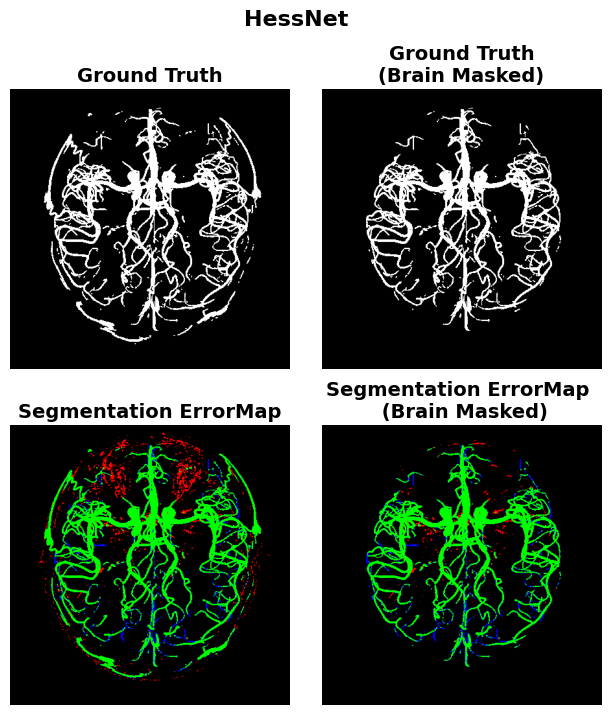

In [73]:
fig, ax = plt.subplots(2, 2, figsize = (8,8), gridspec_kw = {'wspace':0.01, 'hspace':0.2})

ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()

ax[0][0].imshow(MIP_GT, cmap='gray')
ax[0][0].set_title("Ground Truth", fontsize = 14, fontweight ='bold') 
ax[0][1].imshow(MIP_GT_masked, cmap='gray')
ax[0][1].set_title("Ground Truth\n(Brain Masked)", fontsize = 14, fontweight ='bold') 

ax[1][0].imshow(get_errors_image(MIP_SEG, MIP_GT))
ax[1][0].set_title("Segmentation ErrorMap", fontsize = 14, fontweight ='bold') 
ax[1][1].imshow(get_errors_image(MIP_SEG_masked, MIP_GT_masked))
ax[1][1].set_title("Segmentation ErrorMap \n (Brain Masked)", fontsize = 14, fontweight ='bold') 

fig.suptitle(f'{model_name}', fontsize=16, fontweight ='bold')

fig.savefig(f'/home/msst/{model_name}_results.jpg', dpi=100)

In [147]:
def get_error_vol(vol_GT, vol_SEG):
    assert vol_GT.shape == vol_SEG.shape
    error_vol = np.zeros_like(vol_GT, dtype=np.uint8)
    error_vol[(vol_GT>0)*(vol_GT==vol_SEG)] =1
    error_vol[(vol_GT>vol_SEG)]=2
    error_vol[(vol_GT<vol_SEG)]=3
    return(error_vol)

In [150]:
error_vol = get_error_vol(vessels_GT_masked, vessels_SEG_masked)

In [151]:
path_to_save_sample = f'/home/msst/IXI_MRA_work/{sample_name}/{model_name}_ErrorMap.nii.gz'
save_vol_as_nii(error_vol, subject.head.affine, path_to_save_sample)

**<h1>Learning History**

In [184]:
DEVICE = 'cuda'
#model_name = 'Unet2d_16ch'
#model_name = 'Unet3d_16ch'
model_name = 'HessNet'

def get_model(model_name, controller_dict):
    if model_name == 'Unet3d_16ch':
        controller_dict.update({'model' : U_Net(channels=16)})
        IS2D = False
    if model_name == 'Unet2d_16ch':
        controller_dict.update({'model' : U_Net2d(channels=16)})
        IS2D = True
    elif model_name == 'HessNet':
        controller_dict.update({'model' : HessNet(start_scale=[0.8], device=DEVICE)})
        IS2D = False
    return(controller_dict)

controller_dict = {'device' : DEVICE,
                    'is2d' : IS2D}
controller_dict = get_model(model_name, controller_dict)
controller = Controller(controller_dict)

In [185]:
path_to_check = f"/home/msst/save_folder/models_for_tests/{model_name}_test1"
controller.load(path_to_checkpoint=path_to_check)

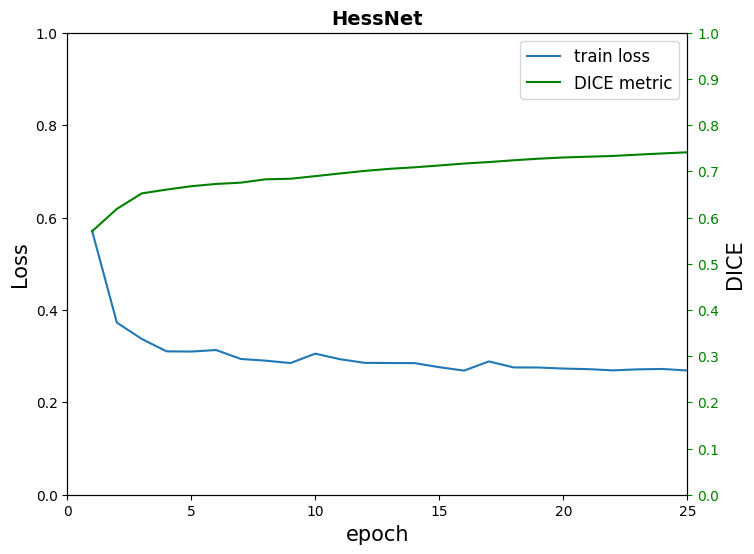

In [186]:
N_ep = len(controller.history['train_loss'])

epochs = np.linspace(1, N_ep, N_ep)
loss_train = controller.history['train_loss']
loss_val = controller.history['val_loss']
all_metrics = controller.history['test_quality']

avg_metrics = []
for epoch_metrics in all_metrics:
    metric = []
    for dict_ in epoch_metrics['metrics']:
        metric.append(dict_['metric1'].numpy())
    avg_metrics.append(sum(metric)/len(metric))


fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) 

ax.set_title(f"{model_name}", fontsize = 14, fontweight ='bold') 

twin1 = ax.twinx()
p1, = ax.plot(epochs, loss_train, label="train loss")
#p2, = ax.plot(epochs, loss_val, label="validation loss")
p3, = twin1.plot(epochs, avg_metrics, "g-", label="DICE metric")

ax.set_xlabel("epoch", fontsize=fontsize+3)
ax.set_ylabel("Loss", fontsize=fontsize+3)
twin1.set_ylabel("DICE", fontsize=fontsize+3)

twin1.tick_params(axis='y', colors=p3.get_color())


#ax.set_xticklabels(np.linspace(0, 50, 11).astype(int), fontsize=fontsize)
ax.set_xticks(np.linspace(0, N_ep, 6).astype(int))

#ax.set_yticklabels(np.linspace(0, 12, 7).astype(int), fontsize=fontsize)
#ax.set_yticks(np.linspace(0, 12, 7))

#twin1.set_yticklabels(np.round(np.linspace(0, 1, 6),1), fontsize=fontsize)
twin1.set_yticks(np.linspace(0, 1, 11))

ax.set_xlim(0, N_ep)
ax.set_ylim(0, 1)
twin1.set_ylim(0, 1)

ax.legend(handles=[p1, p3], fontsize=fontsize)

plt.savefig(f'/home/msst/{model_name}_learning.jpg', dpi=100)